<a href="https://colab.research.google.com/github/laiyenglee/PSO/blob/main/PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np                               #the module numpy is imported as np and it is used to perform a wide variety of mathematical operations on arrays.
import matplotlib.pyplot as plt                  #the module matplotlib.pyplot is imported as plt and it is is a plotting library used for 2D graphics.
import pandas as pd                              #the module pandas is imported as pd and it is used for data analysis.
from typing import Tuple                         #Tuple is imported from typing module and it is used to specify a specific number of expected elements and the type of each position.
#It turns on "inline plotting”.
%matplotlib inline                               

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
#sklearn.metrics is a module in scikit-learn that used to access the quality of predictions and compute the performance metrics like f1 score, recall and precision.
from sklearn.cluster import KMeans
#Implementation of k-means clustering from the popular machine learning package scikit-learn.
from sklearn.preprocessing import normalize
#used for scaling input data set

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#mount Google Drive on runtime
#Read data from google drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data = pd.read_csv('gdrive/My Drive/Bloodtype.txt', sep='\t', header=None)
data.head()
#read data in csv

,0,1,2,3,4,5,6,7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,A
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,A
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,A
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,A
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,A


In [ ]:
class Particle:                                                                               #class Particle is defined.
    def __init__(self, n_clusters, data, use_kmeans=True, w=0.72, c1=2.05, c2=2.05):          #Initialize the parameters
        self.n_clusters = n_clusters                                                          #KMeans clustering
        if use_kmeans:
            k_means = KMeans(n_clusters=self.n_clusters)                                      #create kmeans cluster with n_cluster
            k_means.fit(data)                                                                 #pass the data to cluster
            self.centroids_position = k_means.cluster_centers_                                #centroids position is the location representing the center of the cluster
        else:
            self.centroids_position = data[np.random.choice(list(range(len(data))), self.n_clusters)]

        # each cluster has a centroid which is the center of the cluster
        # assign k random data to k centroids
        self.pbest_value = np.inf
        # personal best position for all the centroids so far
        self.pbest_position = self.centroids_position.copy()
        self.velocity = np.zeros_like(self.centroids_position)
        self.pbest_clustering = None                                                          # best data clustering so far
        # pso parameters w,c1,c2
        self.w = w
        self.c1 = c1
        self.c2 = c2

    def update_pbest(self, data: np.ndarray):
        """
        Updates the personal best score based on the fitness function of particles
        :return:
        """
        # finding out which data points belongs to which cluster
        # find the distance between the data points and the centroids.
        distances = self.get_distances(data=data)
        # the minimum distance between a data point and a centroid indicates that, the point belongs to that cluster.
        clusters = np.argmin(distances, axis=0)  # shape: (len(data),)
        clusters_ids = np.unique(clusters)

        # When the algorithm generates less than n clusters
        # find the cluster id that is missed and generate the centroid position with a random data point
        while len(clusters_ids) != self.n_clusters:
            deleted_clusters = np.where(np.isin(np.arange(self.n_clusters), clusters_ids) == False)[0]
            self.centroids_position[deleted_clusters] = data[np.random.choice(list(range(len(data))), len(deleted_clusters))]
            distances = self.get_distances(data=data)
            clusters = np.argmin(distances, axis=0)
            clusters_ids = np.unique(clusters)

        #new_value is determined according to the fitness function of each particle
        new_value = self.fitness_function(clusters=clusters, distances=distances)
        if new_value < self.pbest_value:
            self.pbest_value = new_value
            self.pbest_position = self.centroids_position.copy()
            self.pbest_clustering = clusters.copy()

    def update_velocity(self, gbest_position: np.ndarray):
        """
        Updates the new velocity based on the current velocity, personal best position and the global best position.
        :parameter gbest_position: vector of best centroid positions among all particles so far
        :return:
        """
        #The new velocity is updated based on the equation (4) in this paper.
        self.velocity = self.w * self.velocity + \
                        self.c1 * np.random.random() * (self.pbest_position - self.centroids_position) + \
                        self.c2 * np.random.random() * (gbest_position - self.centroids_position)

    def move_centroids(self, gbest_position):
        """ 
        Moves the centroids position based on the global best position among the particles.
        """
        #The new position is updated based on the equation (3) in this paper.
        self.update_velocity(gbest_position= gbest_position)
        new_position = self.centroids_position + self.velocity
        self.centroids_position = new_position.copy()

    def get_distances(self, data: np.ndarray) -> np.ndarray:
        """
        Calculates the Euclidean distance between data and centroids
        :parameters data:
        :return: distances: a numpy array of distances (len(centroids) x len(data))
        """
        distances = []
        for centroid in self.centroids_position:
            #The euclidean distance is the square root of sum of absolute squares.
            d = np.linalg.norm(data - centroid, axis=1)
            distances.append(d)
        distances = np.array(distances)
        return distances

    def fitness_function(self, clusters: np.ndarray, distances: np.ndarray) -> float:
        """
        Calculates the fitness function, where
        i is the index of particle
        j is the index of clusters in the particle i
        p is the vector of the input data indices belonging the cluster[ij]
        z[p] is the vector of the input data belonging the cluster[ij]
        d is a vector of distances between z(p) and centroid j
        :parameter clusters:
        :parameter distances:
        :return: J:
        """
        J = 0.0
        for i in range(self.n_clusters):
            p = np.where(clusters == i)[0]
            if len(p):
                d = sum(distances[i][p])
                d /= len(p)
                J += d
        J /= self.n_clusters
        return J

In [ ]:
#class PSOClustering is defined.
class PSOClustering:
    def __init__(self, n_clusters: int, n_particles: int, data: np.ndarray, hybrid=True, w=0.72, c1=2.05, c2=2.05):
        """
        Initializes the parameters of the swarm.
        :param n_clusters: number of clusters
        :param n_particles: number of particles
        :param data: ( number_of_points x dimensions)
        :param hybrid: bool : whether or not use kmeans as seeding
        :param w: w
        :param c1: c1
        :param c2: c2
        """
        self.n_clusters = n_clusters
        self.n_particles = n_particles
        self.data = data

        self.particles = []
        # for storing global best
        self.gbest_position = None
        self.gbest_value = np.inf
        # global best data clustering so far
        # for each data point will contain the cluster number
        self.gbest_clustering = None

        # hybrid PSO algorithm
        self.generate_particles(hybrid, w, c1, c2)

    def print_initial(self, iteration, plot):
        """
        Prints the message of the plotting swarm like number of particles, number of clusters, maximum iterations at the initial.
        """
        print('Initialing the swarm with', self.n_particles, 'PARTICLES, ', self.n_clusters, 'CLUSTERS with', iteration,
              'MAXIMUM ITERATIONS and with PLOT =', plot )
        print('Data=', self.data.shape[0], 'points in', self.data.shape[1], 'dimensions')

    def generate_particles(self, hybrid: bool, w: float , c1: float, c2: float ):
        """
        Generates particles with k clusters and t-dimensional points
        :return:
        """
        for i in range(self.n_particles):
            particle = Particle(n_clusters=self.n_clusters, data=self.data, use_kmeans=hybrid, w=w, c1=c1, c2=c2)
            self.particles.append(particle)

    def update_gbest(self, particle):
        """
        Updates the global best position of the particle according to the fitness function of particle.
        """
        if particle.pbest_value < self.gbest_value:
            self.gbest_value = particle.pbest_value
            self.gbest_position = particle.pbest_position.copy()
            self.gbest_clustering = particle.pbest_clustering.copy()

    def start(self, iteration=2000, plot=False) -> Tuple[np.ndarray, float]:
        """
        Start to plot the clusters of data
        :param plot: = True will plot the global best data clusters
        :param iteration: number of maximum iteration
        :return: (best cluster, best fitness value)
        """
        self.print_initial(iteration, plot)
        progress = []
        # Iterate until the max iteration
        for i in range(iteration):
            if i % 400 == 0:                                                 #plot the global best data clusters for every 400 iterations.
                clusters = self.gbest_clustering
                print('iteration', i, 'GBest =', self.gbest_value)           #print the iteration number and gbest value for every plotting
                print('best clusters so far = ', clusters)

                #determine the style and colour of plotting
                if plot:
                    centroids = self.gbest_position
                    if clusters is not None:
                        plt.scatter(self.data[:, 0], self.data[:, 1], c=clusters, cmap='plasma')
                        plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=50, alpha=0.5)
                        plt.show()
                    else:  # if there is no clusters yet ( iteration = 0 ) plot the data with no clusters
                        plt.scatter(self.data[:, 0], self.data[:, 1])
                        plt.show()

            #Update the personal best and global best of particle.
            for particle in self.particles:
                particle.update_pbest(data=self.data)
                self.update_gbest(particle=particle)

            for particle in self.particles:
                particle.move_centroids(gbest_position=self.gbest_position)
            progress.append([self.gbest_position, self.gbest_clustering, self.gbest_value])

        #Print 'Finished' when the process of PSO clustering is completed.   
        print('Finished!')
        return self.gbest_clustering, self.gbest_value

In [ ]:
# plot the global best data clusters
plot = True
# Read data from the google drive.
data = pd.read_csv('gdrive/My Drive/Bloodtype.txt', sep='\t',error_bad_lines=False, header=None)
# cluster the data based on the values of column[7] of the data.
clusters = data[7].values
#visualize the data by dropping the column[7] of the data.
data = data.drop([7], axis=1)

Initialing the swarm with 50 PARTICLES,  4 CLUSTERS with 2000 MAXIMUM ITERATIONS and with PLOT = True
Data= 200 points in 2 dimensions
iteration 0 GBest = inf
best clusters so far =  None


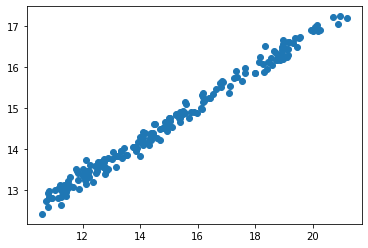

iteration 400 GBest = 0.6386851645939681
best clusters so far =  [3 1 1 1 3 1 1 1 3 3 3 1 1 1 1 1 1 3 1 2 1 1 3 2 1 3 2 2 1 1 1 3 1 1 1 3 3
 3 1 1 1 1 2 3 1 1 3 1 1 1 1 3 1 1 1 1 1 1 3 2 2 2 2 1 2 2 1 1 1 2 0 3 3 0
 3 3 3 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2]


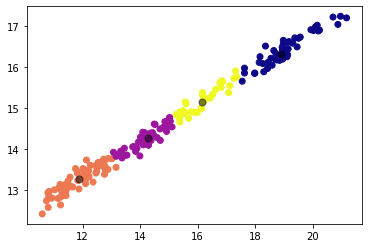

iteration 800 GBest = 0.619413191332626
best clusters so far =  [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 1 3 3 1 1 3 1 1 3 3 3 3 3 3
 0 3 3 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 2 2 1 1 1 1 3 3 3 1 0 0 0 0
 3 3 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0 0 0 0 0 0 0 3 3 3 3 0 3 3 3 1 1 1 1 1 2 2 1
 1 2 2 1 1 2 2 2 2 1 1 2 1 1 1 1 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 2 1
 2 1 2 2 2 2 2 2 2 1 1 1 1 1 1]


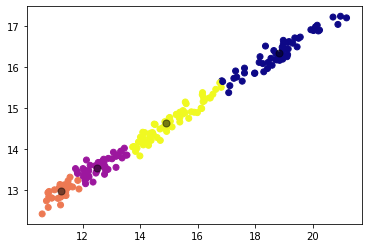

iteration 1200 GBest = 0.6194105837966386
best clusters so far =  [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 1 3 3 1 1 3 1 1 3 3 3 3 3 3
 0 3 3 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 2 2 1 1 1 1 3 3 3 1 0 0 0 0
 3 3 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0 0 0 0 0 0 0 3 3 3 3 0 3 3 3 1 1 1 1 1 2 2 1
 1 2 2 1 1 2 2 2 2 1 1 2 1 1 1 1 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 2 1
 2 1 2 2 2 2 2 2 2 1 1 1 1 1 1]


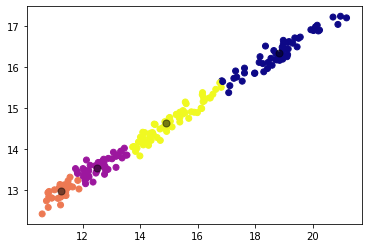

iteration 1600 GBest = 0.618814797144452
best clusters so far =  [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 1 3 3 1 1 3 1 1 3 3 3 3 3 3
 0 3 3 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 2 2 1 1 1 1 3 3 3 1 0 0 0 0
 3 3 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0 0 0 0 0 0 0 3 3 3 3 0 3 3 3 1 1 1 1 1 2 2 1
 1 2 2 1 1 2 2 2 2 1 1 2 1 1 1 1 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 2 1
 2 1 2 2 2 2 2 2 2 1 1 1 1 1 1]


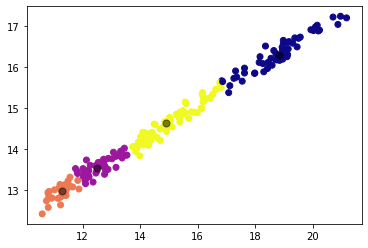

Finished!


(array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3,
        3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 1, 1, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 2, 1, 1, 1, 1,
        3, 3, 3, 1, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        3, 3, 3, 3, 0, 3, 3, 3, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2,
        2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
        1, 1]), 0.6187859414738737)

In [ ]:
# plot by using 2 points of data
if plot:
    data = data[[0, 1]]
# convert to numpy 2d array
data = data.values
# hybrid PSO algorithm is used in 50 particles to cluster the data in 4 clusters.
pso = PSOClustering(n_clusters=4, n_particles=50, data=data, hybrid=True)
# plot the clusters of data for maximum iteration of 2000.
pso.start(iteration=2000, plot=plot)


In [ ]:
# assign 4 clusters
pso_kmeans= KMeans(n_clusters=4)
#pass the data to cluster
pso_kmeans.fit(data)
#apply a trained model to data
y_pred=pso_kmeans.predict(data) 
#identify the maximum value for every row
data=np.argmax(data, axis=1)

In [ ]:
# Compute the f1 score for the data in multiclass or multilabel 
# Calculate metrics for each label, and find their unweighted mean.
print('F1 score:',f1_score(data,y_pred ,average='macro'))

F1 score: 0.25058339052848316


In [ ]:
# Compute the presicion for the data in multiclass or multilabel
# Calculate metrics for each label, and find their unweighted mean.
print('Precision:',precision_score(data,y_pred,average='macro'))

Precision: 0.390625


In [ ]:
# Compute the recall or the data in multiclass or multilabel
# Calculate metrics for each label, and find their unweighted mean.
print('Recall:', recall_score(data,y_pred ,average='macro'))

Recall: 0.1847301778715707


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# For showing the actual clusters
mapping = {'A': 0, 'B': 1, 'AB': 2, 'O':3}
clusters = np.array([mapping[x] for x in clusters])
print('Actual classes = ', clusters)

Actual classes =  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
